In [1]:
import numpy as np
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.colors as mcolors
import coop_post_processing as cpp
#matplotlib settings
from matplotlib import rc
from scipy import ndimage

#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)


# set plot params
plt.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 140



In [26]:
def get_multipole_moment(input_array, Cr, m):
    length = len(input_array)
    coords = np.zeros((length**2,2))
    i = 0
    xmax = input_array.shape[0]
    for index,value in np.ndenumerate(input_array):
        coords[i,0] = index[0]
        coords[i,1] = index[1]
        i += 1
    coords = (coords - xmax//2).astype(int)
    # now convert to polar coordinates
    # r = sqrt(x^2 + y^2)
    # phi = atan2(y,x)
    # make array of [r,phi]
    r_phi      = np.zeros((length**2,2)) 
    r_phi[:,0] = np.sqrt(coords[:,0]**2 + coords[:,1]**2) # r
    r_phi[:,1] = np.arctan2(coords[:,1],coords[:,0]) # phi
    
    in_circle = r_phi[:,0] < 238
    r_phi = r_phi[in_circle]
    coords = coords[in_circle]
    Cr_matches = np.zeros(len(r_phi))
    r_ints = np.round(r_phi[:,0]).astype(int)
    i = 0
    for r in r_ints:
        Cr_closest = Cr[:,m][r] #(make this interpolated later)
        Cr_matches[i] = Cr_closest
        i += 1

    # now make array of cos(mphi) * Cr
    cosmphi = np.cos(m*r_phi[:,1]) * Cr_matches
    
    # and put coords back to starting at (0,0)
    coords = (coords + xmax/2).astype(int)
    # now modify image array by multiplying everywhere by cos(m*phi)
    cosmphi_2d = np.ones(input_array.shape)
    for i in range(len(coords)):
        cosmphi_2d[coords[i][0],coords[i][1]] = cosmphi_2d[coords[i][0],coords[i][1]] * cosmphi[i]
    rotated = np.rot90(cosmphi_2d)
    # I don't understand why this rotation is necessary
    return rotated

def get_multipole_moment_S(input_array, Sr, m):
    length = len(input_array)
    coords = np.zeros((length**2,2))
    i = 0
    xmax = input_array.shape[0]
    for index,value in np.ndenumerate(input_array):
        coords[i,0] = index[0]
        coords[i,1] = index[1]
        i += 1
    coords = (coords - xmax//2).astype(int)
    # now convert to polar coordinates
    # r = sqrt(x^2 + y^2)
    # phi = atan2(y,x)
    # make array of [r,phi]
    r_phi      = np.zeros((length**2,2)) 
    r_phi[:,0] = np.sqrt(coords[:,0]**2 + coords[:,1]**2) # r
    r_phi[:,1] = np.arctan2(coords[:,1],coords[:,0]) # phi
    
    in_circle = r_phi[:,0] < 238
    r_phi = r_phi[in_circle]
    coords = coords[in_circle]
    Sr_matches = np.zeros(len(r_phi))
    r_ints = np.round(r_phi[:,0]).astype(int)
    i = 0
    for r in r_ints:
        Sr_closest = Sr[:,m][r] #(make this interpolated later)
        Sr_matches[i] = Sr_closest
        i += 1

    # now make array of cos(mphi) * Sr
    sinmphi = np.sin(m*r_phi[:,1]) * Sr_matches
    
    # and put coords back to starting at (0,0)
    coords = (coords + xmax/2).astype(int)
    # now modify image array by multiplying everywhere by cos(m*phi)
    sinmphi_2d = np.ones(input_array.shape)
    for i in range(len(coords)):
        sinmphi_2d[coords[i][0],coords[i][1]] = sinmphi_2d[coords[i][0],coords[i][1]] * sinmphi[i]
    rotated = np.rot90(sinmphi_2d)
    # I don't understand why this rotation is necessary
    return rotated

def plot(im_array, rad_in_mpc):
    fig    = plt.figure(figsize=[8,5])
    smoothplot = plt.imshow(np.flipud(ndimage.gaussian_filter(im_array, sigma=8)), cmap='afmhot', vmin=-1e-7, vmax=4e-7)
#, vmax=3.5e-7, vmin=-1e-7
    locs = []
    for i in range(9):
        locs.append(i/8. * im_array.shape[0])

    labels = []
    mpc_per_pix = rad_in_mpc / (im_array.shape[0]//2)
    for loc in locs:
        labels.append(round((loc-im_array.shape[0]//2) * mpc_per_pix.value))

    plt.xlabel("x [cMpc]")
    plt.ylabel("y [cMpc]")
    plt.xticks(locs, labels)
    plt.yticks(locs, labels)

    cbar = fig.colorbar(smoothplot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.set_label('Compton-$y$')
    cbar.update_ticks()
    return(None)

In [3]:
rad_in_Mpc = cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance,(1032+1232)/2.*u.Mpc)).to(u.Mpc/u.deg)*2*u.deg

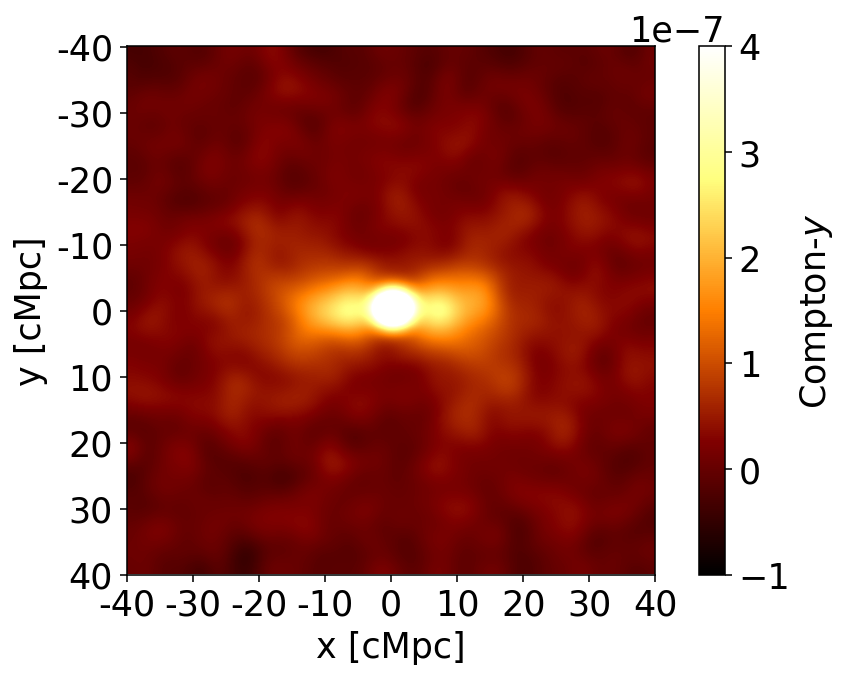

In [4]:
buzz_img_cuts = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/Buzzard_tSZ_rmpks/Buzzard_lambdagt10_1032_2632Mpc_13pt9Mpc_nugt2_egtpt3_smth_24regallreg_combined_stack.txt")
plot(buzz_img_cuts, rad_in_Mpc)

In [5]:
r, Cr, Sr = cpp.radial_decompose_2D(f=buzz_img_cuts, mmax=5)

In [6]:
m0_base = get_multipole_moment(buzz_img_cuts, Cr, 0)
m1_base = get_multipole_moment(buzz_img_cuts, Cr, 1)
m2_base = get_multipole_moment(buzz_img_cuts, Cr, 2)
m3_base = get_multipole_moment(buzz_img_cuts, Cr, 3)
m4_base = get_multipole_moment(buzz_img_cuts, Cr, 4)

In [27]:
m1_base_S = get_multipole_moment_S(buzz_img_cuts, Sr, 1)
m2_base_S = get_multipole_moment_S(buzz_img_cuts, Sr, 2)
m3_base_S = get_multipole_moment_S(buzz_img_cuts, Sr, 3)
m4_base_S = get_multipole_moment_S(buzz_img_cuts, Sr, 4)


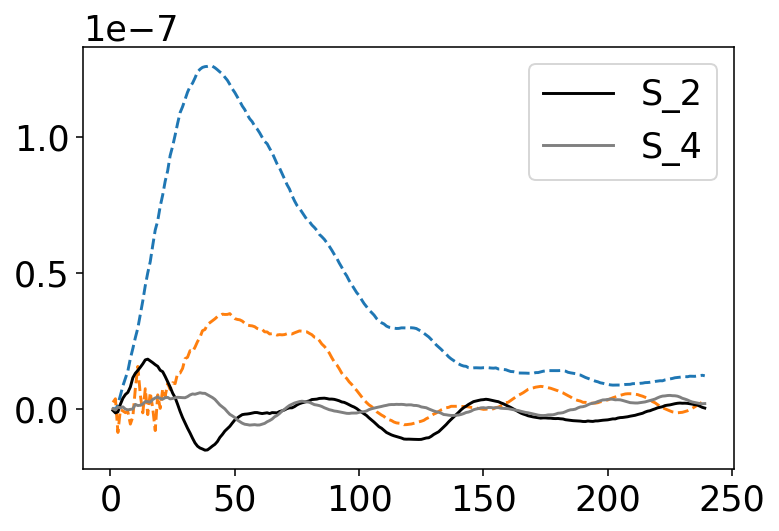

In [9]:
plt.plot(np.arange(1,240), Cr[:,2], '--')
plt.plot(np.arange(1,240), Cr[:,4], '--')
plt.plot(np.arange(1,240), Sr[:,2], 'black', label="S_2")
plt.plot(np.arange(1,240), Sr[:,4], 'grey', label="S_4")
plt.legend()

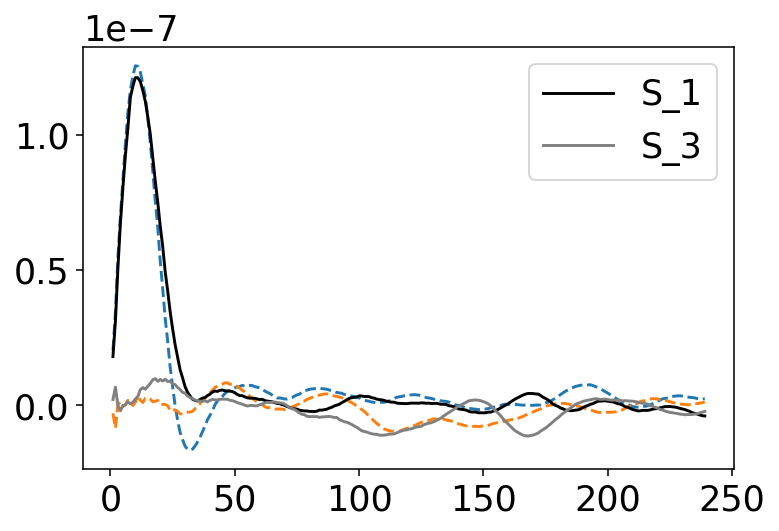

In [12]:
plt.plot(np.arange(1,240), Cr[:,1], '--')
plt.plot(np.arange(1,240), Cr[:,3], '--')
plt.plot(np.arange(1,240), Sr[:,1], 'black', label="S_1")
plt.plot(np.arange(1,240), Sr[:,3], 'grey', label="S_3")
plt.legend()

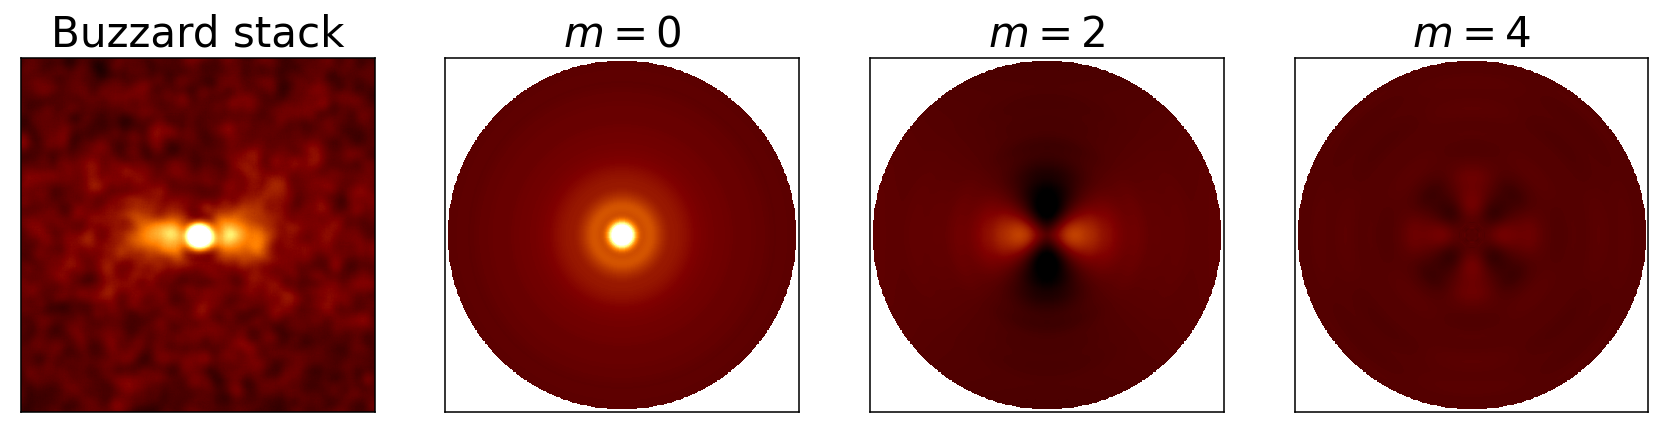

In [13]:
fig, ax = plt.subplots(1,4, figsize=[15,10])

im1 = ax[0].imshow(buzz_img_cuts, cmap='afmhot', vmax=5e-7,vmin = -1e-7)
ax[1].imshow(m0_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[2].imshow(m2_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[3].imshow(m4_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
# ax[4].imshow(m3_base, vmax = 3e-8, cmap = 'afmhot')
# ax[5].imshow(m4_base, vmax = 3e-8, cmap = 'afmhot')
for i in range(1,4):
    ax[i].set_title("$m={:d}$".format(i*2-2))
ax[0].set_title("Buzzard stack")
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.rcParams.update({'font.size': 22})
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/multipole_decomp_vis.png", dpi=400)

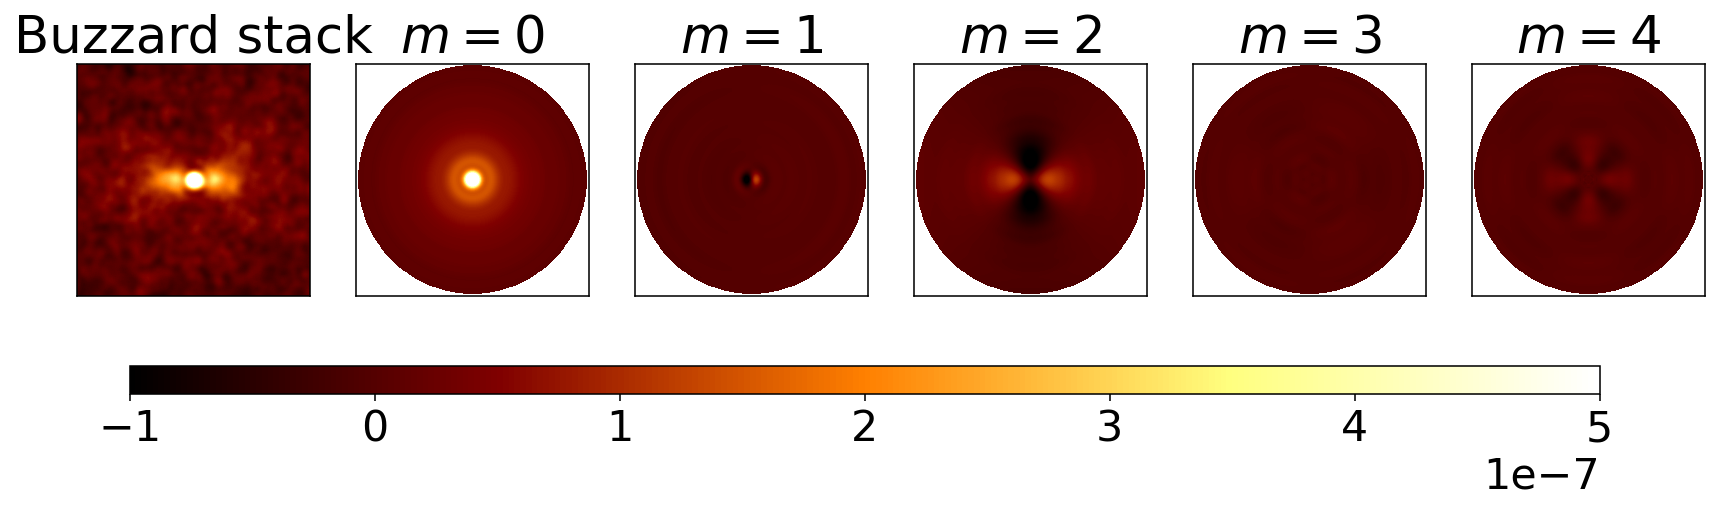

In [24]:
fig, ax = plt.subplots(1,6, figsize=[15,10])

im1 = ax[0].imshow(buzz_img_cuts, cmap='afmhot', vmax=5e-7,vmin = -1e-7)
ax[1].imshow(m0_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[2].imshow(m1_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[3].imshow(m2_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[4].imshow(m3_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[5].imshow(m4_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
# ax[4].imshow(m3_base, vmax = 3e-8, cmap = 'afmhot')
# ax[5].imshow(m4_base, vmax = 3e-8, cmap = 'afmhot')
for i in range(1,6):
    ax[i].set_title("$m={:d}$".format(i-1))
ax[0].set_title("Buzzard stack")
for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.rcParams.update({'font.size': 22})
# add colorbar below
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.02])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/multipole_decomp_vis.png", dpi=400)

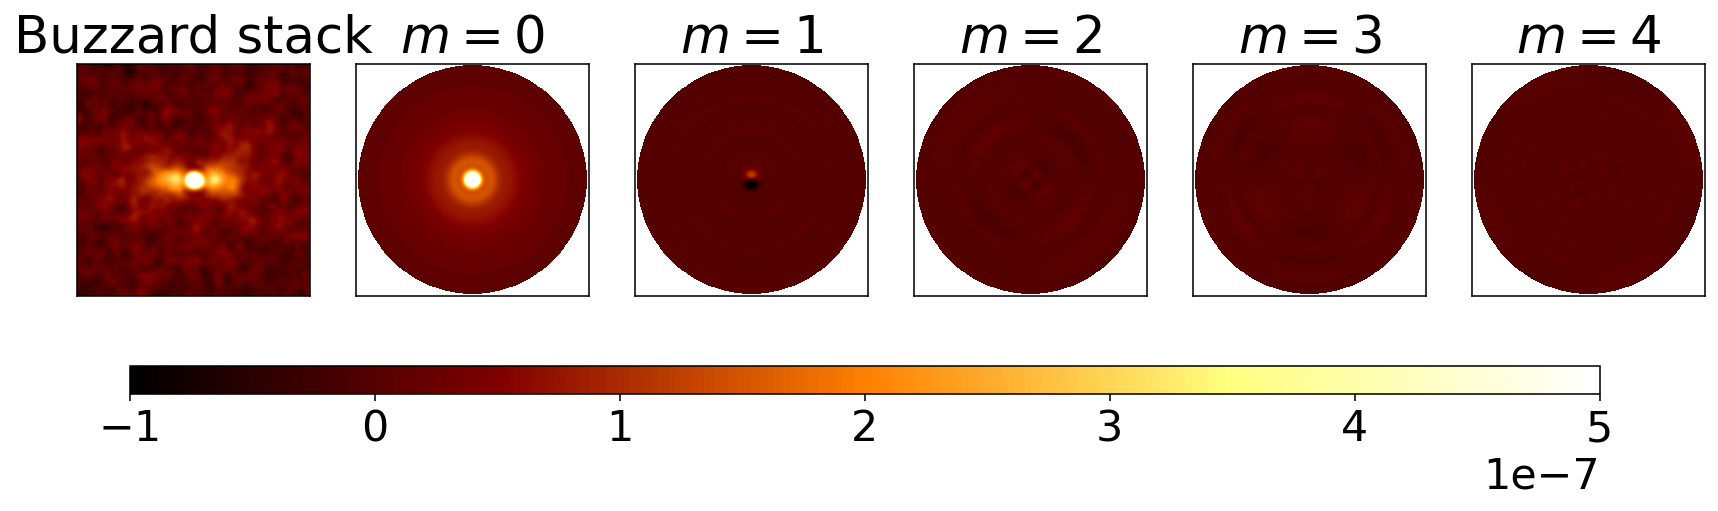

In [28]:
fig, ax = plt.subplots(1,6, figsize=[15,10])

im1 = ax[0].imshow(buzz_img_cuts, cmap='afmhot', vmax=5e-7,vmin = -1e-7)
ax[1].imshow(m0_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[2].imshow(m1_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[3].imshow(m2_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[4].imshow(m3_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[5].imshow(m4_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
# ax[4].imshow(m3_base, vmax = 3e-8, cmap = 'afmhot')
# ax[5].imshow(m4_base, vmax = 3e-8, cmap = 'afmhot')
for i in range(1,6):
    ax[i].set_title("$m={:d}$".format(i-1))
ax[0].set_title("Buzzard stack")
for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.rcParams.update({'font.size': 22})
# add colorbar below
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.02])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/multipole_decomp_vis.png", dpi=400)

# Test for asymmetric +x, +y stacks.

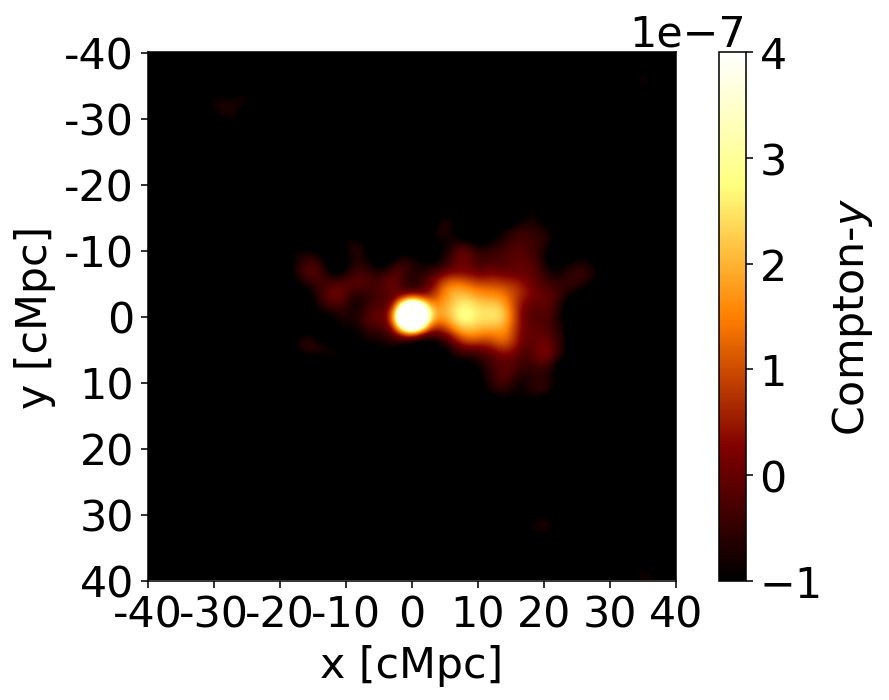

In [54]:
act_img_asym = np.loadtxt("/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/ilc_SZ_yy_4096_hpx_redmapper_lambdagt20_combined_1093_2593Mpc_nugt2_egtpt3_17pt8_orientXYUP_100pct_maglim_1043_2643Mpc_stack.txt")
plot(act_img_asym, rad_in_Mpc)

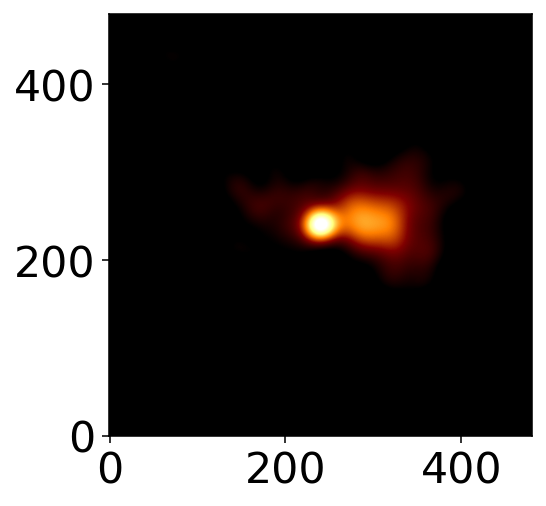

In [82]:
# smooth the image a bit first
act_img_asym = ndimage.gaussian_filter(act_img_asym, sigma=8)
plt.imshow(act_img_asym, cmap='afmhot', vmax=5e-7,vmin = -1e-7, origin='lower')

In [57]:
r, Cr, Sr = cpp.radial_decompose_2D(f=act_img_asym, mmax=5)

In [58]:
m0_base = get_multipole_moment(act_img_asym, Cr, 0)
m1_base = get_multipole_moment(act_img_asym, Cr, 1)
m2_base = get_multipole_moment(act_img_asym, Cr, 2)
m3_base = get_multipole_moment(act_img_asym, Cr, 3)
m4_base = get_multipole_moment(act_img_asym, Cr, 4)

In [59]:
m1_base_S = get_multipole_moment_S(act_img_asym, Sr, 1)
m2_base_S = get_multipole_moment_S(act_img_asym, Sr, 2)
m3_base_S = get_multipole_moment_S(act_img_asym, Sr, 3)
m4_base_S = get_multipole_moment_S(act_img_asym, Sr, 4)


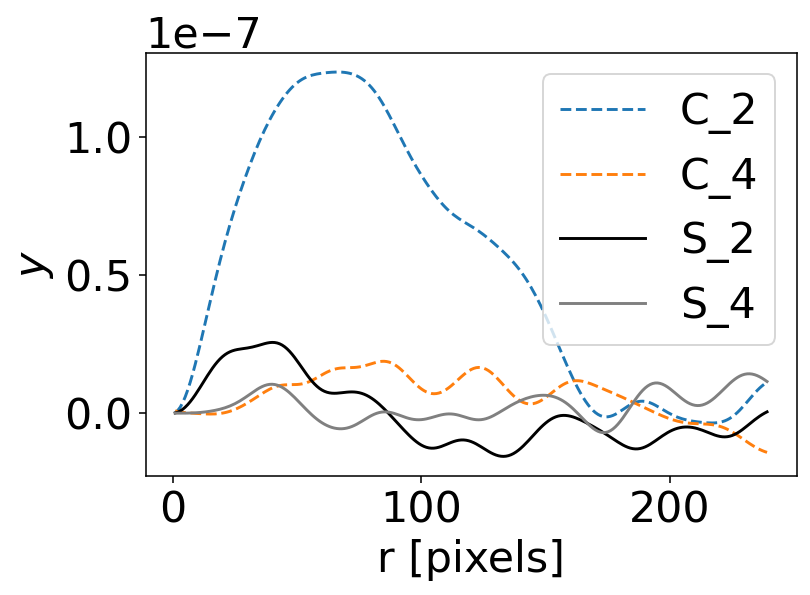

In [68]:
plt.plot(np.arange(1,240), Cr[:,2], '--', label="C_2")
plt.plot(np.arange(1,240), Cr[:,4], '--', label="C_4")
plt.plot(np.arange(1,240), Sr[:,2], 'black', label="S_2")
plt.plot(np.arange(1,240), Sr[:,4], 'grey', label="S_4")
plt.ylabel(r"$y$")
plt.xlabel("r [pixels]" )
plt.legend()

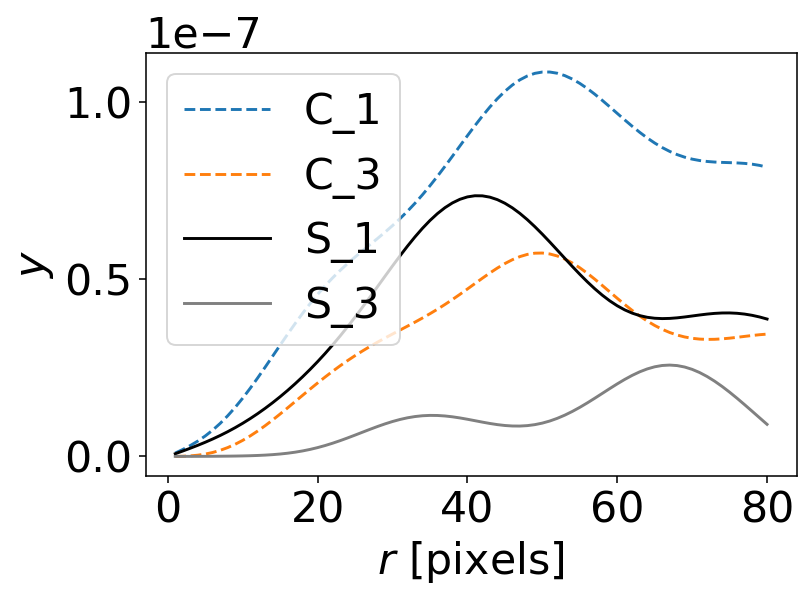

In [79]:
stop=80
# plt.plot(np.arange(1,240), Cr[:,1], '--', label="C_1")
# plt.plot(np.arange(1,240), Cr[:,3], '--', label="C_3")
# plt.plot(np.arange(1,240), Sr[:,1], 'black', label="S_1")
# plt.plot(np.arange(1,240), Sr[:,3], 'grey', label="S_3")
plt.plot(np.arange(1,stop+1), Cr[:,1][:stop], '--', label="C_1")
plt.plot(np.arange(1,stop+1), Cr[:,3][:stop], '--', label="C_3")
plt.plot(np.arange(1,stop+1), Sr[:,1][:stop], 'black', label="S_1")
plt.plot(np.arange(1,stop+1), Sr[:,3][:stop], 'grey', label="S_3")

plt.ylabel(r"$y$")
plt.xlabel(r"$r$ [pixels]")
plt.legend()

In [80]:
np.average(Sr[:,1][:stop]/Cr[:,1][:stop]), np.average(Sr[:,3][:stop]/Cr[:,3][:stop])

(0.6121854251381074, 0.2814997431984949)

Text(0.5, 0.98, 'ACTxDES DR6 stack, cosines')

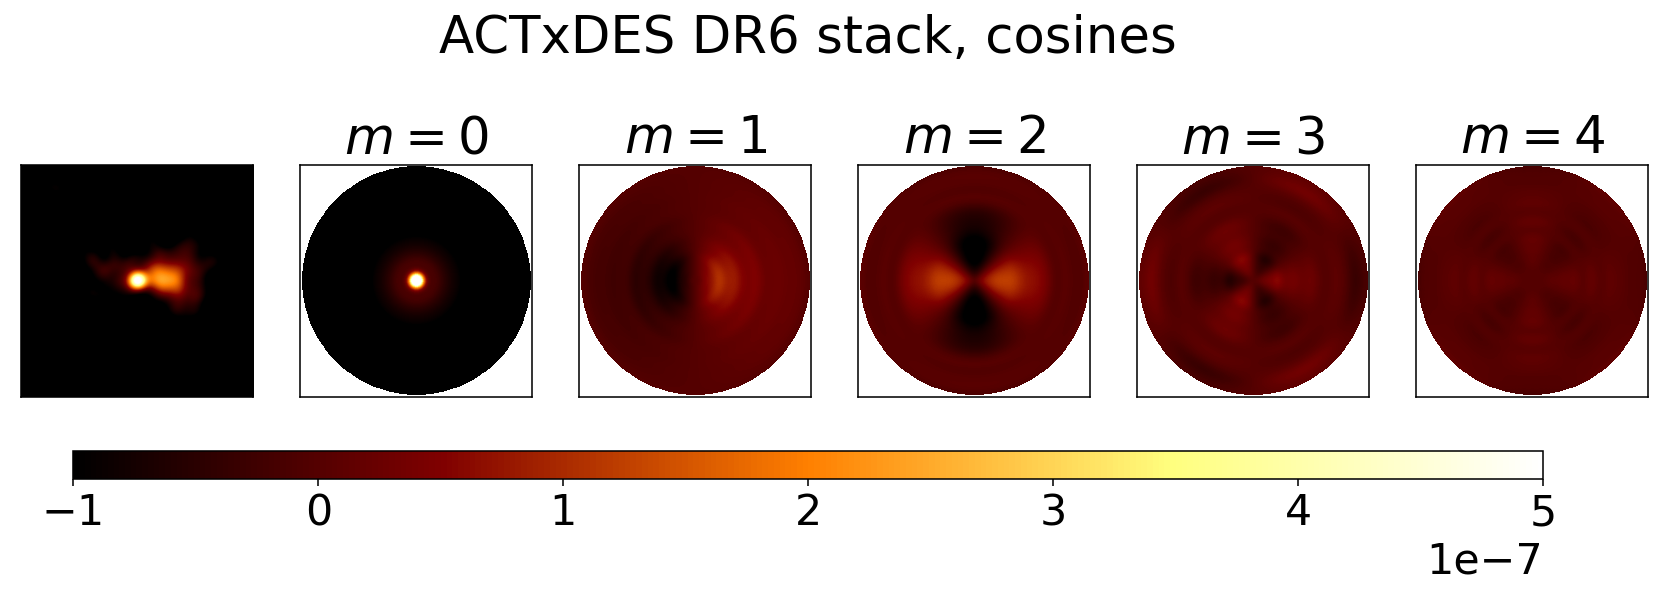

In [83]:
fig, ax = plt.subplots(1,6, figsize=[15,4])

im1 = ax[0].imshow(act_img_asym, cmap='afmhot', vmax=5e-7,vmin = -1e-7, origin='lower')
ax[1].imshow(m0_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[2].imshow(m1_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[3].imshow(m2_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[4].imshow(m3_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[5].imshow(m4_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
# ax[4].imshow(m3_base, vmax = 3e-8, cmap = 'afmhot')
# ax[5].imshow(m4_base, vmax = 3e-8, cmap = 'afmhot')
for i in range(1,6):
    ax[i].set_title("$m={:d}$".format(i-1))

for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.rcParams.update({'font.size': 22})
# add colorbar below
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
plt.suptitle("ACTxDES DR6 stack, cosines")
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/multipole_decomp_vis.png", dpi=400)

Text(0.5, 0.98, 'ACTxDES DR6 stack, sines')

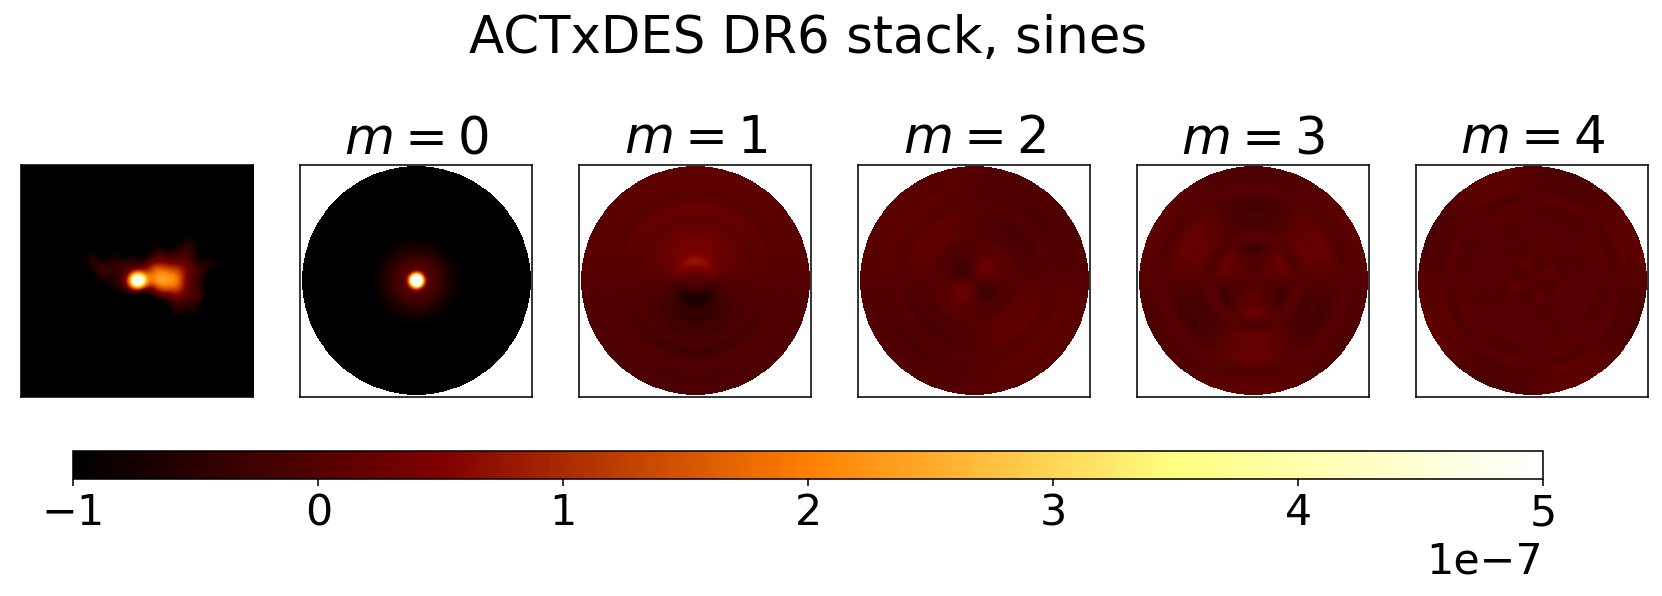

In [84]:
fig, ax = plt.subplots(1,6, figsize=[15,4])

im1 = ax[0].imshow(act_img_asym, cmap='afmhot', vmax=5e-7,vmin = -1e-7, origin='lower')
ax[1].imshow(m0_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[2].imshow(m1_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[3].imshow(m2_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[4].imshow(m3_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
ax[5].imshow(m4_base_S, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
# ax[4].imshow(m3_base, vmax = 3e-8, cmap = 'afmhot')
# ax[5].imshow(m4_base, vmax = 3e-8, cmap = 'afmhot')
for i in range(1,6):
    ax[i].set_title("$m={:d}$".format(i-1))

for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.rcParams.update({'font.size': 22})
# add colorbar below
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
plt.suptitle("ACTxDES DR6 stack, sines")
# plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/multipole_decomp_vis.png", dpi=400)

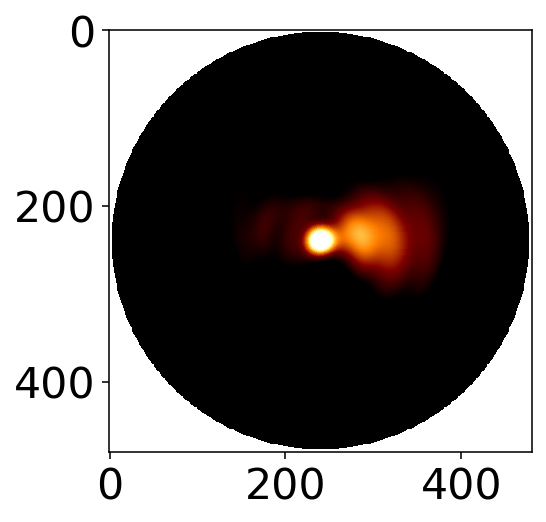

In [81]:
tot_img = m0_base + m1_base + m2_base + m3_base + m4_base + m1_base_S + m2_base_S + m3_base_S + m4_base_S
plt.imshow(tot_img, cmap='afmhot', vmax=5e-7,vmin = -1e-7)

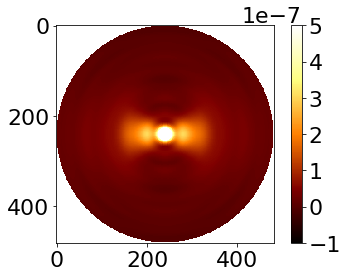

In [10]:
plt.imshow(m0_base + m2_base+m4_base, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot') 
plt.colorbar()

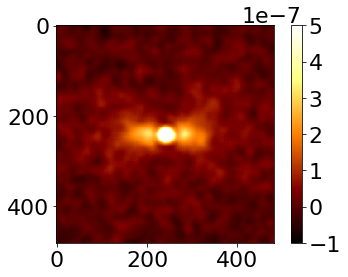

In [11]:
plt.imshow(buzz_img_cuts, vmax = 5e-7, vmin=-1e-7, cmap = 'afmhot')
plt.colorbar()

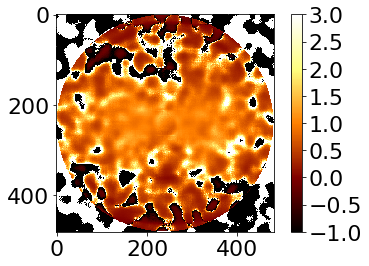

In [12]:
plt.imshow((m0_base+m2_base+m4_base)/buzz_img_cuts, vmin=-1,vmax=3, cmap='afmhot')
plt.colorbar()

In [13]:
r2, Cr2, Sr2 = cpp.radial_decompose_2D(f=m2_base, mmax=5)

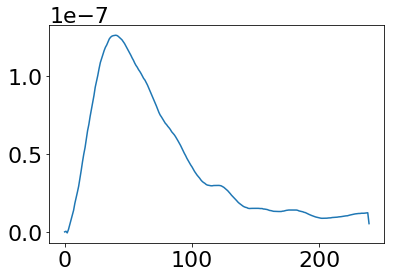

In [18]:
# plt.plot(np.arange(240),Cr2[:,0])
# plt.plot(np.arange(240),Cr2[:,1])
plt.plot(np.arange(240),Cr2[:,2])

In [22]:
Cr_test = np.ones((240,5))

In [24]:
m2_base = get_multipole_moment(buzz_img_cuts, Cr_test, 2)


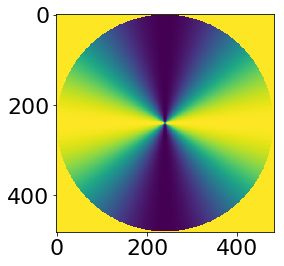

In [25]:
plt.imshow(m2_base)

In [77]:
def radial_decompose_2D(f, mmax):
        # f is numpy image array                                                                                                                                             \
        import math
        # mmax is maximum m for decomposition (maximally 10)                                                                                                                 \

        n = int(f.shape[0] // 2)
        nsteps = n * 20
        dtheta = 2*np.pi/nsteps
        Cr = np.zeros((n, mmax))
        Sr = np.zeros((n, mmax))

        for i in range(n):
                r = float(i)
                avg_boxsize = []
                for j in range(nsteps):
                        # print(j)                                                                                                                                           \
                                                                                                                                                                              
                        theta = dtheta * j
                        print(theta, dtheta*(j+1))

                        rx    = r*np.cos(theta)
                        ry    = r*np.sin(theta)
                        ix    = min(math.floor(rx), n-1)
                        iy    = min(math.floor(ry), n-1)
                        rx    = rx - ix
                        ry    = ry - iy
                        ix    = ix + n # different from Fortran COOP version -- indexing middle of array                                                                     \
                                                                                                                                                                              
                        iy    = iy + n
                        fv    = (1-rx)*(f[iy, ix]*(1-ry) + f[iy+1, ix]*ry) + rx * ( f[iy, ix+1]*(1-ry) + f[iy+1, ix+1]*ry)
#                         print(f[iy,ix], f[iy+1, ix], f[iy+1, ix+1], f[iy,ix+1])
                        avg_boxsize.append((1-rx)*(1-ry))

                        Cr[i,0] += fv
                        for m in range(1, mmax):
                                Cr[i,m] = Cr[i,m] + fv * np.cos(m*theta)
                                Sr[i,m] = Sr[i,m] + fv * np.sin(m*theta)
                        # print("cos2theta ", np.cos(2*theta)) 
                        break
#                 print(np.average(np.asarray(avg_boxsize)))
        Cr[0:n,0] = Cr[0:n, 0]/nsteps
        Cr[0:n,1:mmax] =  Cr[0:n,1:mmax] * (2./nsteps)
        Sr[0:n,1:mmax] =  Sr[0:n,1:mmax] * (2./nsteps)
        return(np.arange(n), Cr, Sr)



In [78]:
r, Cr, Sr = radial_decompose_2D(buzz_img_cuts, 3)

0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747
0.0 0.001308996938995747


# Find a different function

In [3]:
# an alternative: measure the FWHM at every point along the horizontal axis?